# Pastas and Metran example

This notebook shows how output from Pastas time series models can be analyzed using Metran.

In [1]:
import os

import hydropandas as hpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

import metran

ps.logger.setLevel("ERROR")

metran.show_versions()

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
numpy version: 1.26.4
scipy version: 1.12.0
pandas version: 2.0.3
matplotlib version: 3.8.3
pastas version: 1.4.0
numba version: 0.59.0
lmfit version: 1.2.2


## Read data

Load the observed heads from piezometers at different depths at location B21B0214. The outliers (values outside of $5 \sigma$ (std. dev.)) are removed from the time series.

In [2]:
oc = hpd.read_dino("./data", subdir=".")

In [3]:
oc

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
B21B0214-001,198085.0,518413.0,B21B0214001_1,dino,m NAP,B21B0214,1.0,-7.3,-9.3,-0.29,0.24,True,GroundwaterObs B21B0214-001 -----metadata-----...
B21B0214-003,198085.0,518413.0,B21B0214003_1,dino,m NAP,B21B0214,3.0,-24.3,-26.3,-0.29,0.25,True,GroundwaterObs B21B0214-003 -----metadata-----...
B21B0214-002,198085.0,518413.0,B21B0214002_1,dino,m NAP,B21B0214,2.0,-15.3,-17.3,-0.29,0.28,True,GroundwaterObs B21B0214-002 -----metadata-----...
B21B0214-004,198085.0,518413.0,B21B0214004_1,dino,m NAP,B21B0214,4.0,-36.3,-38.3,-0.29,0.23,True,GroundwaterObs B21B0214-004 -----metadata-----...
B21B0214-005,198085.0,518413.0,B21B0214005_1,dino,m NAP,B21B0214,5.0,-51.3,-53.3,-0.29,0.21,True,GroundwaterObs B21B0214-005 -----metadata-----...


In [4]:
oseries = {}

for o in oc.obs:
    name = o.name
    o = o["stand_m_tov_nap"].rename(o.name)

    # remove outliers outside 5*std
    mean = o.median()
    std = o.std()
    mask_outliers = (o - mean).abs() > 5 * std

    ts = o.copy()
    ts.loc[mask_outliers] = np.nan

    # store time series
    oseries[name] = ts

In [5]:
# sort the names
sorted_names = list(oseries.keys())
sorted_names.sort()
sorted_names

['B21B0214-001',
 'B21B0214-002',
 'B21B0214-003',
 'B21B0214-004',
 'B21B0214-005']

Plot the heads:

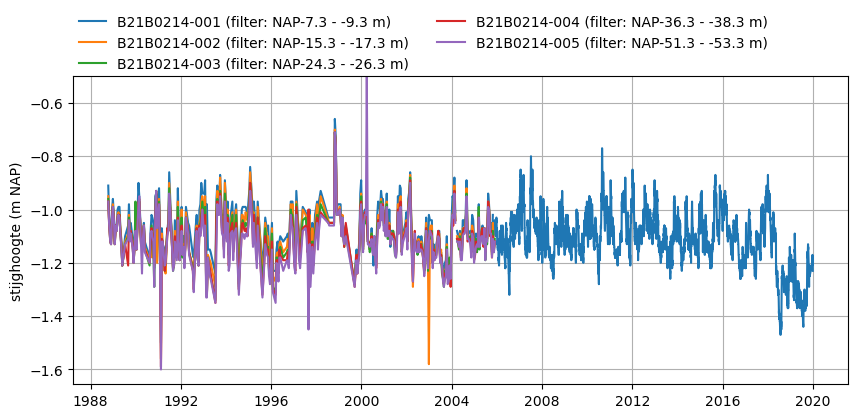

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for name in sorted_names:
    o = oseries[name]
    ftop = oc.loc[name, "screen_top"]
    fbot = oc.loc[name, "screen_bottom"]
    lbl = f"{name} (filter: NAP{ftop:+.1f} - {fbot:+.1f} m)"
    ax.plot(o.index, o, label=lbl)

ax.set_ylabel("stijghoogte (m NAP)")
ax.legend(loc=(0, 1), ncol=2, frameon=False)
ax.set_ylim(top=-0.5)
ax.grid(True)

Load the precipitation and evaporation data from two nearby weather stations

In [7]:
p = pd.read_csv(
    "./data/RD_338.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "RD"]
)
e = pd.read_csv(
    "./data/EV24_260.csv", index_col=[0], parse_dates=True, usecols=["YYYYMMDD", "EV24"]
)

Plot precipitation and evaporation time series

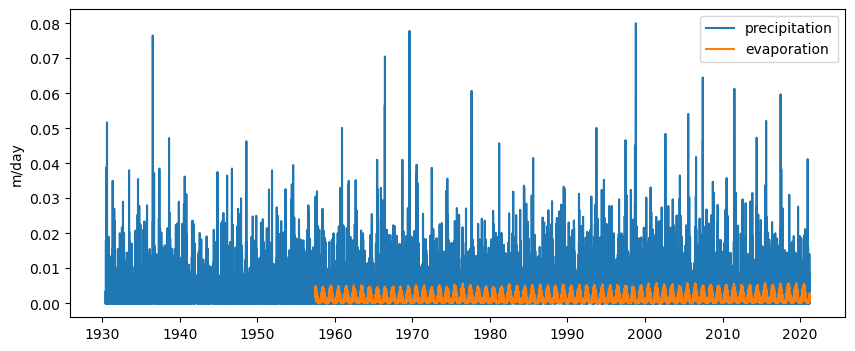

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(p.index, p, label="precipitation")
ax.plot(e.index, e, label="evaporation")
ax.set_ylabel("m/day")
ax.legend(loc="best")

## Build time series models

The time series models attempt to simulate the heads using recharge as stress. The recharge is calculated using $R  = P - f \cdot E$, where $R$ is recharge, $P$ is precipitation, $E$ is evaporation and $f$ is factor that is optimized. The model fit results are printed to the console. The model residuals are stored for analysis with Metran.

In [9]:
# Normalize the index (reset observation time to midnight (the end of the day)).
p.index = p.index.normalize()
e.index = e.index.normalize()

# set tmin/tmax
tmin = "1988-10-14"
tmax = "2005-11-28"

# store models and residuals
models = []
residuals = []

for name in sorted_names:
    # create model
    ml = ps.Model(oseries[name])
    rm = ps.RechargeModel(prec=p, evap=e)
    ml.add_stressmodel(rm)

    # solve model
    ml.solve(tmin=tmin, tmax=tmax, report=False)

    # print fit statistic
    print(name, f"EVP = {ml.stats.evp():.1f}%")

    # store model
    models.append(ml)

    # get residuals
    r = ml.residuals()
    r.name = name
    residuals.append(r)

B21B0214-001 EVP = 68.4%
B21B0214-002 EVP = 58.9%
B21B0214-003 EVP = 66.8%
B21B0214-004 EVP = 61.3%
B21B0214-005 EVP = 51.0%


## Build Metran model

A Metran model is created using the residuals of the time series models. By analyzing the model residuals we can determine for example, whether there is a common pattern in the residuals, which could indicate a missing influence, or a shortcoming in the model structure. Additionally we might be able to analyze whether there are still outliers left in our time series.

In [10]:
mt = metran.Metran(residuals)
mt.solve()

INFO: Number of factors according to Velicer's MAP test: 1



Fit report Cluster                  Fit Statistics
tmin     None                       obj       3223.12
tmax     None                       nfev            7
freq     D                          AIC       3235.12
solver   ScipySolve                                  

Parameters (6 were optimized)
                        optimal   stderr initial  vary
B21B0214-001_sdf_alpha       10  ±10.00%      10  True
B21B0214-002_sdf_alpha       10  ±10.00%      10  True
B21B0214-003_sdf_alpha       10  ±10.00%      10  True
B21B0214-004_sdf_alpha       10  ±10.00%      10  True
B21B0214-005_sdf_alpha       10  ±10.00%      10  True
cdf1_alpha                   10  ±10.00%      10  True

Parameter correlations |rho| > 0.5
None

Metran report Cluster          Factor Analysis
tmin     None                nfct      1
tmax     None                fep     81.32%
freq     D                              

Communality
                        
B21B0214-001      84.36%
B21B0214-002      67.77%
B21B0214-003 

Plot the specific and common dynamic components

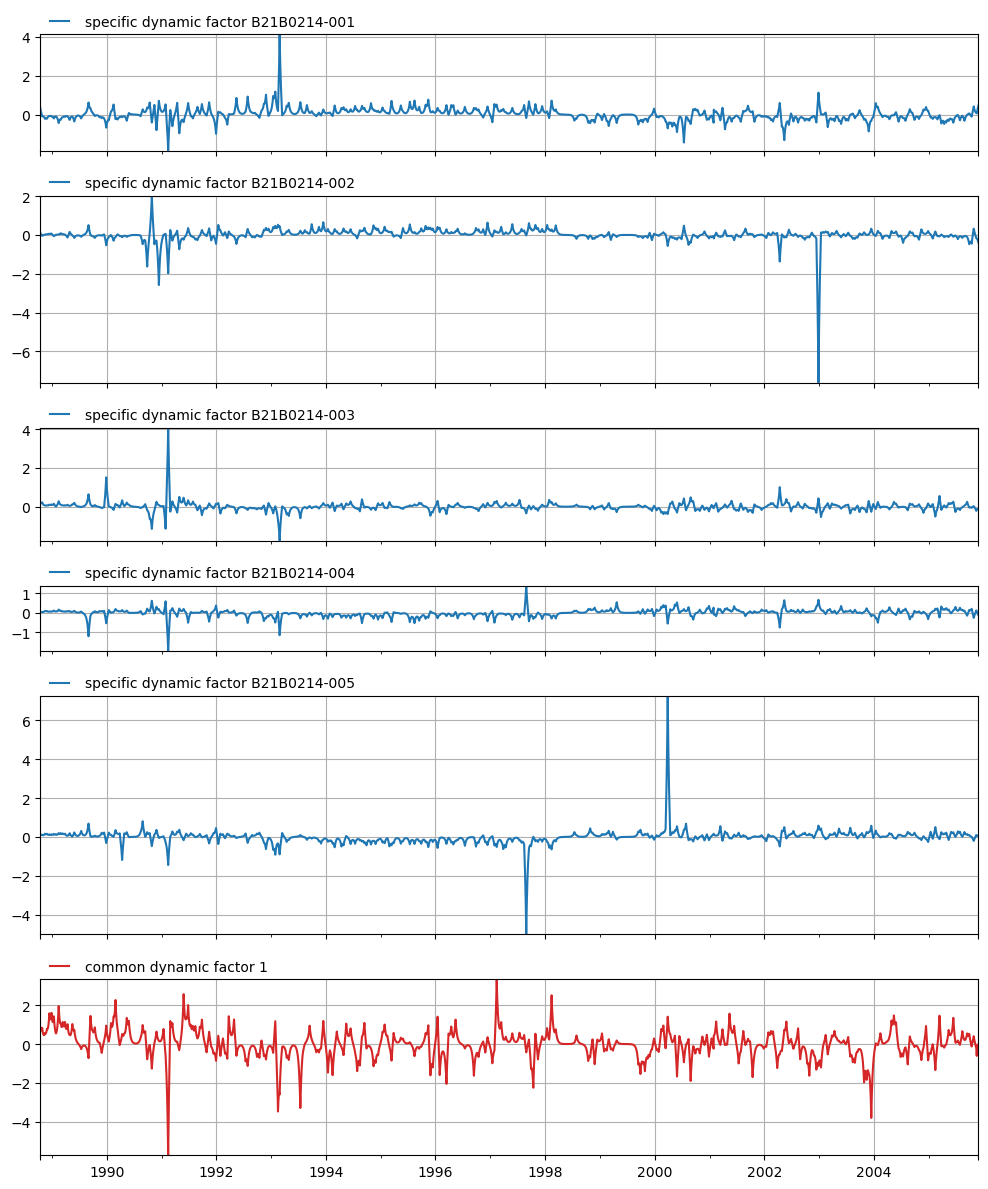

In [11]:
axes = mt.plots.state_means()

Plot a simulation, including a confidence interval for B21B0214003.

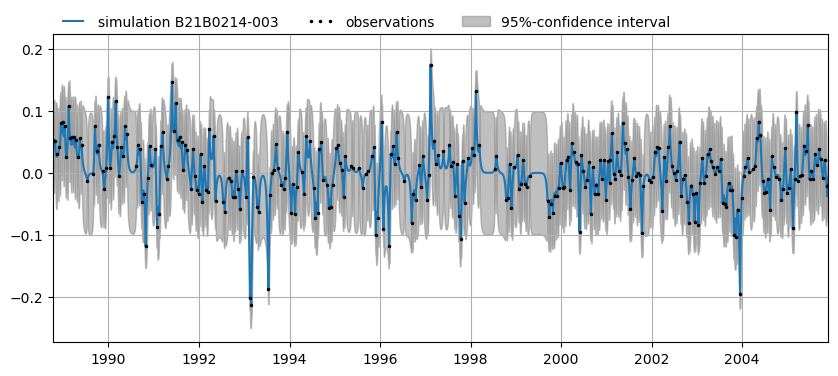

In [12]:
ax = mt.plots.simulation(mt.snames[2])